# TensorFlow Recommenders (TFRS) - First Stage: Retrieval (The Two Towers Model)

![logo_small](https://user-images.githubusercontent.com/67468718/127299425-533f0a3c-c965-42a5-886a-5272170d9e0e.JPG)


## Contents:

 1. Introduction
 2. Dataset
 3. Sourcing and Loading:
  * Import relevant libraries
  * preparing the dataset
 4. Implementing a Retrieval Model:
  * The query tower
  * The candidate tower
  * Metrics
  * The Full Model (The Two Towers)
  * Fitting and evaluating
  * Visualization: Total loss and Accuracy over epochs
 5. Making predictions
 6. Model serving

## 1. Introduction

**Real-world recommender systems are often composed of two stages:**

 * The retrieval stage (Selects recommendation candidates): is responsible for selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, it has to be computationally efficient.

 * The ranking stage (Selects the best candidates and rank them): takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations. Its task is to narrow down the set of items the user may be interested in to a shortlist of likely candidates.


**Retrieval models are often composed of two sub-models:**

The retrieval model embeds user ID's and movie ID's of rated movies into embedding layers of the same dimension:

 * A query model computing the query representation (normally a fixed-dimensionality embedding vector) using query features.
 * A candidate model computing the candidate representation (an equally-sized vector) using the candidate features.
 
As shown below, the two models are multiplied to create a query-candidate affinity scores for each rating during training. If the affinity score for the rating is higher than other for other candidates , then we can consider the model is a good one!!.  
<p align="center">
  <img width="600" height="600" src="https://user-images.githubusercontent.com/67468718/127304344-6aa3770f-a7d9-421c-b2d9-98123dac79ef.JPG">
</p>

**Embedding layer Magic!!!**

As shown above, we might think of the **embedding layers** as just a way of encoding right a way of forcing the categorical data into some sort of a standard format that can be easily fed into a neural network and usually that's how it's used but embedding layers are more than that!!. The way they're working under the hood is every unique id is being mapped to a vector of n dimensions maybe it's 32 dimensions or 64 dimensions, but it's going to be like a vector of 32 floating point values and we can think of this as a position in a 32-dimensional space that represents the similarity between one user id and another or between one movie id and another so by using **embedding layers** in this way we're kind of getting around that whole problem of **data sparsity** and **sparse vectors** and at the same time, we're getting a measure of similarity out of the deal as well so it's a very simple and straightforward way of getting a recommendation candidates and then we could just brute force sort them all and get our top k recommendations.


The outputs of the two models are then multiplied together to give a query-candidate affinity score, with higher scores expressing a better match between the candidate and the query.

In this Notebook, we're going to build and train such a two-tower model using the Movielens dataset (1m Dataset).

We're going to:

 * Get our data and split it into a training and test set.
 * Implement a retrieval model.
 * Fit and evaluate it.
 * Export it for efficient serving by building an approximate nearest neighbours (ANN) index.

## 2. Dataset: 

**Movie Lens** contains a set of movie ratings from the MovieLens website, a movie recommendation service. This dataset was collected and maintained by [GroupLens](https://grouplens.org/) , a research group at the University of Minnesota. There are 5 versions included: "25m", "latest-small", "100k", "1m", "20m". In all datasets, the movies data and ratings data are joined on "movieId". The 25m dataset, latest-small dataset, and 20m dataset contain only movie data and rating data. The 1m dataset and 100k dataset contain demographic data in addition to movie and rating data.

**movie_lens/1m** can be treated in two ways:

  * It can be interpreted as expressesing which movies the users watched (and rated), and which they did not. This is a form of *implicit feedback*, where users' watches tell us which things they prefer to see and which they'd rather not see (This means that every movie a user watched is a positive example, and every movie they have not seen is an implicit negative example).
  * It can also be seen as expressesing how much the users liked the movies they did watch. This is a form of *explicit feedback*: given that a user watched a movie, we can tell roughly how much they liked by looking at the rating they have given.



**(a) [movie_lens/1m-ratings](https://www.tensorflow.org/datasets/catalog/movie_lens#movie_lens1m-ratings):**
 * Config description: This dataset contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens. Ratings are in whole-star increments. This dataset contains demographic data of users in addition to data on movies and ratings.
 * This dataset is the largest dataset that includes demographic data from movie_lens.
 * "user_gender": gender of the user who made the rating; a true value corresponds to male
 * "bucketized_user_age": bucketized age values of the user who made the rating, the values and the corresponding ranges are:
   * 1: "Under 18"
   * 18: "18-24"
   * 25: "25-34"
   * 35: "35-44"
   * 45: "45-49"
   * 50: "50-55"
   * 56: "56+"
 * "user_occupation_label": the occupation of the user who made the rating represented by an integer-encoded label; labels are preprocessed to be consistent across different versions
 * "user_occupation_text": the occupation of the user who made the rating in the original string; different versions can have different set of raw text labels
 * "user_zip_code": the zip code of the user who made the rating.
 * Download size: 5.64 MiB
 * Dataset size: 308.42 MiB
 * Auto-cached ([documentation](https://www.tensorflow.org/datasets/performances#auto-caching)): No
 * Features:
 ```
 FeaturesDict({
               'bucketized_user_age': tf.float32,
               'movie_genres': Sequence(ClassLabel(shape=(), dtype=tf.int64, num_classes=21)),
               'movie_id': tf.string,
               'movie_title': tf.string,
               'raw_user_age': tf.float32,
               'timestamp': tf.int64,
               'user_gender': tf.bool,
               'user_id': tf.string,
               'user_occupation_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=22),
               'user_occupation_text': tf.string,
               'user_rating': tf.float32,
               'user_zip_code': tf.string,
              })
 ```
**Example:**

|bucketized_user_age	|movie_genres|	movie_id|	movie_title|	raw_user_age|	timestamp|	user_gender|	user_id	|user_occupation_label|	user_occupation_text	|user_rating	|user_zip_code|
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
|45.0	|7 (Drama)|b'357'	|b"One Flew Over the Cuckoo's Nest (1975)"	|46.0	|879024327	|True	|b'138'	|4 (doctor/health care)	|b'doctor'	|4.0|	b'53211'|


**(b) [movie_lens/1m-movies](https://www.tensorflow.org/datasets/catalog/movie_lens#movie_lens1m-movies):**

 * Config description: This dataset contains data of approximately 3,900 movies rated in the 1m dataset.
 * Download size: 5.64 MiB
 * Dataset size: 351.12 KiB
 * Auto-cached ([documentation](https://www.tensorflow.org/datasets/performances#auto-caching)): Yes
 * Features:
```
FeaturesDict({
              'movie_genres': Sequence(ClassLabel(shape=(), dtype=tf.int64, num_classes=21)),
              'movie_id': tf.string,
              'movie_title': tf.string,
             })
```
**Example:**

|movie_genres	|movie_id	|movie_title|
|:-----:|:-----:|:-----:|
|4 (Comedy) |b'1681'	|b'You So Crazy (1994)'|	
|0 (Action)|b'838'	|b'In the Line of Duty 2 (1987)'|


## 3. Sourcing and Loading

### 3.1 Import relevant libraries

In [7]:
# Import the necessary Libararies: 

import os
import pprint
import tempfile
import matplotlib.pyplot as plt
from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Dict, Text
import pandas as pd
import numpy as np

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

plt.style.use('ggplot')

### 3.2 Preparing the dataset

Let's first have a look at the data.

We use the MovieLens dataset from Tensorflow Datasets. Loading **[movie_lens/1m-ratings](https://www.tensorflow.org/datasets/catalog/movie_lens#movie_lens1m-ratings)** yields a ***tf.data.Dataset*** object containing the ratings data and loading **[movie_lens/1m-movies](https://www.tensorflow.org/datasets/catalog/movie_lens#movie_lens1m-movies)** yields a ***tf.data.Dataset*** object containing only the movies data.

Note that since the MovieLens dataset does not have predefined splits, all data are under train split.

In [30]:
# Ratings data.
ratings = tfds.load("movielens/1m-ratings", split="train", shuffle_files=True)
# Features of all the available movies.
movies = tfds.load("movielens/1m-movies", split="train", shuffle_files=True)

In [31]:
#The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:
#View the data from ratings dataset:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'bucketized_user_age': 18.0,
 'movie_genres': array([1, 3, 8], dtype=int64),
 'movie_id': b'2',
 'movie_title': b'Jumanji (1995)',
 'timestamp': 965806208,
 'user_gender': True,
 'user_id': b'3887',
 'user_occupation_label': 17,
 'user_occupation_text': b'college/grad student',
 'user_rating': 3.0,
 'user_zip_code': b'80513'}


In [32]:
#The movies dataset contains the movie id, movie title, and data on what genres it belongs to. Note that the genres are encoded with integer labels:
#View the data from movies dataset:
for x in movies.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'movie_genres': array([5, 7], dtype=int64),
 'movie_id': b'1729',
 'movie_title': b'Jackie Brown (1997)'}


In [33]:
type(ratings)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

Next, we're only going to extract the movie title and the user id. So, we're actually not going to extract the rating itself and the reason why is that we're treating these as **implicit recommendations** in this case because that's easier to do a large scale like we mentioned earlier we want to try to keep things simple in **the retrieval stage** because it's operating over potentially a massive amount of data so to that end we're just going to assume that any movie that a user rated is one that they were really interested in if they took the time to watch it then it expresses some level of interest:

***Any rating is an implicit positive rating for a movie and the absence of a rating is an implicit negative rating for that movie***

In [34]:
#Let's select the necessary attributes:

ratings = ratings.map(lambda x: {
                                 "movie_title": x["movie_title"],
                                 "user_id": x["user_id"],
                                })

movies = movies.map(lambda x: x["movie_title"])

In [65]:
len(ratings)

1000209

In [36]:
# let's use a random split, putting 75% of the ratings in the train set, and 25% in the test set:
# Assign a seed=42 for consistency of results and reproducibility:
seed = 42
l = len(ratings)

tf.random.set_seed(seed)
shuffled = ratings.shuffle(l, seed=seed, reshuffle_each_iteration=False)

#Save 75% of the data for training and 25% for testing:
train_ = int(0.75 * l)
test_ = int(0.25 * l)

train = shuffled.take(train_)
test = shuffled.skip(train_).take(test_)

In [37]:
# Now, let's find out how many uniques users/movies:
movie_titles = movies.batch(l)
user_ids = ratings.batch(l).map(lambda x: x["user_id"])

#Movies uniques:
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))

#users unique
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# take a look at the movies:
unique_movie_titles[:10]

array([b'$1,000,000 Duck (1971)', b"'Night Mother (1986)",
       b"'Til There Was You (1997)", b"'burbs, The (1989)",
       b'...And Justice for All (1979)', b'1-900 (1994)',
       b'10 Things I Hate About You (1999)', b'101 Dalmatians (1961)',
       b'101 Dalmatians (1996)', b'12 Angry Men (1957)'], dtype=object)

In [38]:
#Movies uniques
len_films = len(unique_movie_titles)
print(len_films) 

3883


In [39]:
#users unique
len_users = len(unique_user_ids)
print(len_users) 

6040


## 4. Implementing a Retrieval Model:

Choosing the architecture of our model is a key part of modelling.

Because we are building a two-tower retrieval model, we can build each tower separately and then combine them in the final model.

### 4.1 The query tower:

Let's start with the query tower.

The first step is to decide on the dimensionality of the query and candidate representations:

In [40]:
#Higher values will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting:
embedding_dimension = 32

In [41]:
#We define the embedding on the user side, we must transform the user ids into a vector representation:
#we're going to use Keras preprocessing layers to first convert user ids to integers, and then convert those to user embeddings via an Embedding layer:
user_model = tf.keras.Sequential([
                                  tf.keras.layers.experimental.preprocessing.StringLookup(
                                  #User_ids vocabulary: list of unique integers that represents each user_id
                                  vocabulary=unique_user_ids, mask_token=None),
                                  # We add an additional embedding to account for unknown tokens.
                                  tf.keras.layers.Embedding(len(unique_user_ids) + 1, 
                                  embedding_dimension)#embedding layer with a vector size of 32
                                ])


# So, basically we want an embedding layer for however many user ids we have where each one is represented by a vector of 32 floating point values that 
# basically represents in that 64-dimensional space how similar users 


### 4.2 The candidate tower:


In [42]:
# We now define the embedding of the movie portion 
movie_model = tf.keras.Sequential([
                                  tf.keras.layers.experimental.preprocessing.StringLookup(
                                  vocabulary=unique_movie_titles, mask_token=None),
                                  tf.keras.layers.Embedding(len(unique_movie_titles) + 1,
                                  embedding_dimension) #embedding layer with a vector size of 32
                                 ])

### 4.3 Metrics

In our training data we have positive (user, movie) pairs. To figure out how good our model is, we need to compare the affinity score that the model calculates for this pair to the scores of all the other possible candidates: if the score for the positive pair is higher than for all other candidates, our model is highly accurate.

To do this, we can use the tfrs.metrics.FactorizedTopK metric. The metric has one required argument: the dataset of candidates that are used as implicit negatives for evaluation.

In our case, that's the movies dataset, converted into embeddings via our movie model:



In [43]:
#We define the desired metrics : FactorizedTopK
metrics = tfrs.metrics.FactorizedTopK(
                                     candidates=movies.batch(128).map(movie_model)
                                     )

In [44]:
#The Retrieval task is defined according to the FactorizedTopK metrics:
task = tfrs.tasks.Retrieval(
                            metrics=metrics
                           )

### 4.4 The Full Model

We can now put it all together into a model. TFRS exposes a base model class (tfrs.models.Model) which streamlines building models: all we need to do is to set up the components in the __init__ method, and implement the compute_loss method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.

In [45]:
class MovielensModel(tfrs.Model):
    
    def __init__(self, user_model, movie_model):
        super().__init__()
        #The Two Towers: Movie and user Models:
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_movie_embeddings = self.movie_model(features["movie_title"])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_movie_embeddings)

The tfrs.Model base class is a simply convenience class: it allows us to compute both training and test losses using the same method.

Under the hood, it's still a plain Keras model. You could achieve the same functionality by inheriting from tf.keras.Model and overriding the train_step and test_step functions (see [the guide](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details):

In [46]:
class NoBaseClassMovielensModel(tf.keras.Model):

    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        # Set up a gradient tape to record gradients.
        with tf.GradientTape() as tape:

            # Loss computation.
            user_embeddings = self.user_model(features["user_id"])
            positive_movie_embeddings = self.movie_model(features["movie_title"])
            loss = self.task(user_embeddings, positive_movie_embeddings)

            # Handle regularization losses as well.
            regularization_loss = sum(self.losses)

            total_loss = loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

    def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        # Loss computation.
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        loss = self.task(user_embeddings, positive_movie_embeddings)

        # Handle regularization losses as well.
        regularization_loss = sum(self.losses)

        total_loss = loss + regularization_loss

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

### 4.5 Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [47]:
#Let's first instantiate the model.
model = MovielensModel(user_model, movie_model)

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [48]:
# Then shuffle, batch, and cache the training and evaluation data:
# Segment the batches so that the model runs 13 training batches (2^13) and 11 test batches (2^11) per epoch, 
# while having a batch size which is a multiple of 2^n.
cached_train = train.shuffle(l).batch(8192).cache()
cached_test = test.batch(2048).cache()

In [49]:
# Then, let's train the model:
history_train = model.fit(cached_train, validation_data = cached_test, epochs=32)

Epoch 1/32
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


92/92 [==============================] - 425s 4s/step - factorized_top_k/top_1_categorical_accuracy: 6.7453e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0072 - factorized_top_k/top_10_categorical_accuracy: 0.0153 - factorized_top_k/top_50_categorical_accuracy: 0.0736 - factorized_top_k/top_100_categorical_accuracy: 0.1329 - loss: 71273.8821 - regularization_loss: 0.0000e+00 - total_loss: 71273.8821 - val_factorized_top_k/top_1_categorical_accuracy: 0.0022 - val_factorized_top_k/top_5_categorical_accuracy: 0.0139 - val_factorized_top_k/top_10_categorical_accuracy: 0.0273 - val_factorized_top_k/top_50_categorical_accuracy: 0.1110 - val_factorized_top_k/top_100_categorical_accuracy: 0.1897 - val_loss: 932.4714 - val_regularization_loss: 0.0000e+00 - val_total_loss: 932.4714
Epoch 2/32
92/92 [==============================] - 458s 5s/step - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.0126 - factorized_top_k/top_10_categorical

92/92 [==============================] - 436s 5s/step - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accuracy: 0.0164 - factorized_top_k/top_10_categorical_accuracy: 0.0328 - factorized_top_k/top_50_categorical_accuracy: 0.1308 - factorized_top_k/top_100_categorical_accuracy: 0.2194 - loss: 66376.1901 - regularization_loss: 0.0000e+00 - total_loss: 66376.1901 - val_factorized_top_k/top_1_categorical_accuracy: 0.0023 - val_factorized_top_k/top_5_categorical_accuracy: 0.0147 - val_factorized_top_k/top_10_categorical_accuracy: 0.0290 - val_factorized_top_k/top_50_categorical_accuracy: 0.1179 - val_factorized_top_k/top_100_categorical_accuracy: 0.2005 - val_loss: 865.1389 - val_regularization_loss: 0.0000e+00 - val_total_loss: 865.1389
Epoch 22/32
92/92 [==============================] - 433s 5s/step - factorized_top_k/top_1_categorical_accuracy: 0.0016 - factorized_top_k/top_5_categorical_accuracy: 0.0163 - factorized_top_k/top_10_categorical_ac

As the model trains, the loss is falling and a set of top-k retrieval metrics is updated. These tell us whether the true positive is in the top-k retrieved items from the entire candidate set. For example, a top-5 categorical accuracy metric of 0.2 would tell us that, on average, the true positive is in the top 5 retrieved items 20% of the time.

### 4.6 Visualization: Total loss and Accuracy over epochs

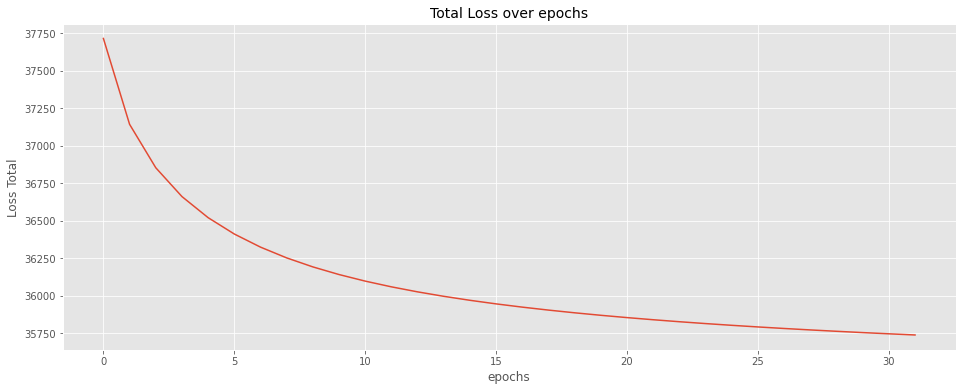

In [63]:
plt.subplots(figsize = (16,6))
plt.plot(history_train.history['total_loss'] )
plt.title("Total Loss over epochs", fontsize=14)
plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.show()


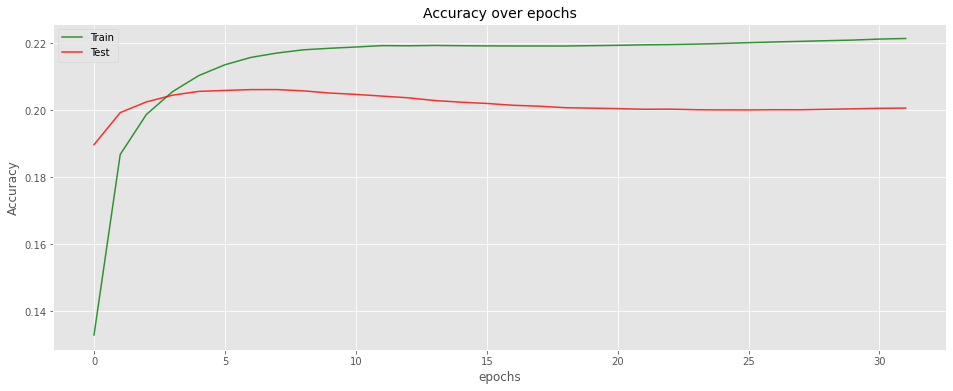

In [64]:
plt.subplots(figsize = (16,6))
plt.plot(history_train.history['factorized_top_k/top_100_categorical_accuracy'],color='green', alpha=0.8, label='Train' )
plt.plot(history_train.history['val_factorized_top_k/top_100_categorical_accuracy'],color='red', alpha=0.8, label='Test' )
plt.title("Accuracy over epochs", fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.show()

In [57]:
#Evaluate the model
model.evaluate(cached_test, return_dict=True)

123/123 [==============================] - 30s 245ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0023 - factorized_top_k/top_5_categorical_accuracy: 0.0145 - factorized_top_k/top_10_categorical_accuracy: 0.0284 - factorized_top_k/top_50_categorical_accuracy: 0.1168 - factorized_top_k/top_100_categorical_accuracy: 0.2007 - loss: 13848.8548 - regularization_loss: 0.0000e+00 - total_loss: 13848.8548


{'factorized_top_k/top_1_categorical_accuracy': 0.002323516644537449,
 'factorized_top_k/top_5_categorical_accuracy': 0.01446499116718769,
 'factorized_top_k/top_10_categorical_accuracy': 0.028442084789276123,
 'factorized_top_k/top_50_categorical_accuracy': 0.11681970208883286,
 'factorized_top_k/top_100_categorical_accuracy': 0.20065826177597046,
 'loss': 862.669677734375,
 'regularization_loss': 0,
 'total_loss': 862.669677734375}

Test set performance is much worse than training performance. This is due to two factors:

 * Our model is likely to perform better on the data that it has seen, simply because it can memorize it. This overfitting phenomenon is especially strong when models have many parameters. It can be mediated by model regularization and use of user and movie features that help the model generalize better to unseen data.
 * The model is re-recommending some of users' already watched movies. These known-positive watches can crowd out test movies out of top K recommendations.

The second phenomenon can be tackled by excluding previously seen movies from test recommendations. This approach is relatively common in the recommender systems literature, but we don't follow it in these tutorials. If not recommending past watches is important, we should expect appropriately specified models to learn this behaviour automatically from past user history and contextual information. Additionally, it is often appropriate to recommend the same item multiple times (say, an evergreen TV series or a regularly purchased item).

## 5. Making predictions

Now that we have a model, we would like to be able to make predictions. We can use the tfrs.layers.factorized_top_k.BruteForce layer to do this.

In [72]:
# Recommend the 5 best movies for user 42:

# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)

# recommends movies out of the entire movies dataset.
index.index(movies.batch(100).map(model.movie_model), movies)

# Get recommendations.
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :5]}")

Recommendations for user 42: [b'Dune (1984)' b'Arrival, The (1996)' b'Nineteen Eighty-Four (1984)'
 b'Adventures of Buckaroo Bonzai Across the 8th Dimension, The (1984)'
 b"Logan's Run (1976)"]


## 6. Model serving

After the model is trained, we need a way to deploy it.

In a two-tower retrieval model, serving has two components:

 * a serving query model, taking in features of the query and transforming them into a query embedding, and
 * a serving candidate model. This most often takes the form of an approximate nearest neighbours (ANN) index which allows fast approximate lookup of candidates in response to a query produced by the query model.
 
In TFRS, both components can be packaged into a single exportable model, giving us a model that takes the raw user id and returns the titles of top movies for that user. This is done via exporting the model to a SavedModel format, which makes it possible to serve using [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).

To deploy a model like this, we simply export the BruteForce layer we created above:

In [ ]:
# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
    path = os.path.join(tmp, "model")

  # Save the index.
    index.save(path)

  # Load it back; can also be done in TensorFlow Serving.
    loaded = tf.keras.models.load_model(path)

  # Pass a user id in, get top predicted movie titles back.
    scores, titles = loaded(["42"])
    
    print(f"Recommendations: {titles[0][:5]}")

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))